In [ ]:
!ls /usr/local/cuda*

/usr/local/cuda:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json

/usr/local/cuda-11:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json

/usr/local/cuda-11.2:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json


In [ ]:
!nvidia-smi

Fri Dec 16 22:09:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%writefile histo.cu

#include<math.h>
#include <stdio.h>
#include<time.h>
#include <iostream>
#include <sys/time.h>
#include <stdlib.h>
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "device_functions.h"
using namespace std;

#define BLOCK_SIZE 512
#define NUM_BINS 4096
#define MAX_VAL 127
#define PRIVATE 4096

double cpuSecond() {
   struct timeval tp;
   gettimeofday(&tp,NULL);
   return ((double)tp.tv_sec + (double)tp.tv_usec*1.e-6);
}

// histogramCPU computes the histogram of an input array on the CPU
void histogramCPU(unsigned int* input, unsigned int* bins, unsigned int numElems) {
    for (int i=0; i<numElems; i++) {
        if (bins[input[i]] < MAX_VAL) {
            bins[input[i]]++;
        }
    }
}

// histogramGPU computes the histogram of an input array on the GPU
__global__ void histogramGPU(unsigned int* input, unsigned int* bins, unsigned int numElems) {
    int tx = threadIdx.x; int bx = blockIdx.x;

    // compute global thread coordinates
    int i = (bx * blockDim.x) + tx;

    // create a private histogram copy for each thread block
    __shared__ unsigned int hist[PRIVATE];

    // each thread must initialize more than 1 location
    if (PRIVATE > BLOCK_SIZE) {
        for (int j=tx; j<PRIVATE; j+=BLOCK_SIZE) {
            if (j < PRIVATE) {
                hist[j] = 0;
            }
        }
    }
    // use the first `PRIVATE` threads of each block to init
    else {
        if (tx < PRIVATE) {
            hist[tx] = 0;
        }
    }
    // wait for all threads in the block to finish
    __syncthreads();

    // update private histogram
    if (i < numElems) {
        atomicAdd(&(hist[input[i]]), 1);
    }
    // wait for all threads in the block to finish
    __syncthreads();

    // each thread must update more than 1 location
    if (PRIVATE > BLOCK_SIZE) {
        for (int j=tx; j<PRIVATE; j+=BLOCK_SIZE) {
            if (j < PRIVATE) {
                atomicAdd(&(bins[j]), hist[j]);
            }
        }
    }
    // use the first `PRIVATE` threads to update final histogram
    else {
        if (tx < PRIVATE) {
            atomicAdd(&(bins[tx]), hist[tx]);
        }
    }
}

// saturateGPU caps the bin frequencies to a maximum value of 127
__global__ void saturateGPU(unsigned int* bins, unsigned int numBins) {
    // global thread coordinates
    int i = (blockIdx.x * blockDim.x) + threadIdx.x;

    if (i < numBins) {
        if (bins[i] > MAX_VAL) {
            bins[i] = MAX_VAL;
        }
    }
}

int main(void) {
    // timers
    double timer1, timer2, timer3, timer4;

    // data params
    int inputLength;
    unsigned int* hostBins_CPU;
    unsigned int* hostInput; unsigned int* hostBins;
    unsigned int* deviceInput; unsigned int* deviceBins;

    // ask the user to enter the length of the input vector
    printf("Please enter the length of the input array\n");
    scanf("%d", &inputLength);

    // determine
    size_t histoSize = NUM_BINS * sizeof(unsigned int);
    size_t inSize = inputLength * sizeof(unsigned int);

    // allocate host memory
    hostInput = (unsigned int*)malloc(inSize);
    hostBins = (unsigned int*)malloc(histoSize);
    hostBins_CPU = (unsigned int*)malloc(histoSize);

    // randomly initialize input array
    srand(clock());
    for (int i=0; i<inputLength; i++) {
        hostInput[i] = int((float)rand()*(NUM_BINS-1)/float(RAND_MAX));
    }
    // for (int i=0; i<inputLength; i++) {
    //     printf("%d, ", hostInput[i]);
    // }
    // printf("\n");

    // allocate device memory
    cudaMalloc((void**)&deviceInput, inSize);
    cudaMalloc((void**)&deviceBins, histoSize);
    cudaMemset(deviceBins, 0, histoSize);


    // host2device transfer
    timer1 = cpuSecond();
    cudaMemcpy(deviceInput, hostInput, inSize, cudaMemcpyHostToDevice);
    cudaDeviceSynchronize();
    double d_t1 = cpuSecond() - timer1;
    printf("Time to copy the input array from the host to the device is: %f sec.\n", d_t1);

    // kernel launch
    dim3 threadPerBlock(BLOCK_SIZE, 1, 1);
    dim3 blockPerGrid(ceil(inputLength/(float)BLOCK_SIZE), 1, 1);
    timer2 = cpuSecond();
    histogramGPU<<<blockPerGrid, threadPerBlock>>>(deviceInput, deviceBins, inputLength);
    cudaDeviceSynchronize();
    double d_t2 = cpuSecond() - timer2;
    printf("Implemented CUDA code for basic histogram calculation ran in: %f secs.\n", d_t2);

    // saturate the bins
    threadPerBlock.x = BLOCK_SIZE;
    blockPerGrid.x = ceil(NUM_BINS/(float)BLOCK_SIZE);
    timer3 = cpuSecond();
    saturateGPU<<<blockPerGrid, threadPerBlock>>>(deviceBins, NUM_BINS);
    cudaDeviceSynchronize();
    double d_t3 = cpuSecond() - timer3;
    printf("Implemented CUDA code for output saturation ran in: %f secs.\n", d_t3);

    // device2host transfer
    timer4 = cpuSecond();
    cudaMemcpy(hostBins, deviceBins, histoSize, cudaMemcpyDeviceToHost);
    double d_t4 = cpuSecond() - timer4;
    printf("Time to copy the resulting Histogram from the device to the host is: %f secs.\n", d_t4);

    // initialize CPU histogram array to 0
    for (int i=0; i<NUM_BINS; i++) {
        hostBins_CPU[i] = 0;
    }

    // run the CPU version
    clock_t begin = clock();
    histogramCPU(hostInput, hostBins_CPU, inputLength);
    clock_t end = clock();

    // printf("CPU: \n");
    // for (int i=0; i<NUM_BINS; i++) {
    //     printf("%d, ", hostBins_CPU[i]);
    // }
    // printf("\n");
    // printf("GPU: \n");
    // for (int i=0; i<NUM_BINS; i++) {
    //     printf("%d, ", hostBins[i]);
    // }

    // calculate total time for CPU and GPU
    double time_spent = (double)(end - begin) / CLOCKS_PER_SEC*1000;
    double total_device_time = d_t1 + d_t2 + d_t3 + d_t4;
    float speedup = (float)time_spent / total_device_time;
    printf("Total CPU code ran in: %f msecs.\n", time_spent);
    printf("Total GPU code ran in: %f secs.\n", total_device_time);
    printf("GPU Speedup: %f\n", speedup);


  
    // release resources
    free(hostBins); free(hostBins_CPU); free(hostInput);
    cudaFree(deviceInput); cudaFree(deviceBins);

    return 0;
}

Overwriting histo.cu


In [ ]:
!nvcc histo.cu -o histo

In file included from histo.cu:10:0:
/usr/local/cuda/bin/../targets/x86_64-linux/include/device_functions.h:54:2: warning: #warning "device_functions.h is an internal header file and must not be used directly.  This file will be removed in a future CUDA release.  Please use cuda_runtime_api.h or cuda_runtime.h instead." [-Wcpp]
 #warning "device_functions.h is an internal header file and must not be used directly.  This file will be removed in a future CUDA release.  Please use cuda_runtime_api.h or cuda_runtime.h instead."
  ^~~~~~~
In file included from histo.cu:10:0:
/usr/local/cuda/bin/../targets/x86_64-linux/include/device_functions.h:54:2: warning: #warning "device_functions.h is an internal header file and must not be used directly.  This file will be removed in a future CUDA release.  Please use cuda_runtime_api.h or cuda_runtime.h instead." [-Wcpp]
 #warning "device_functions.h is an internal header file and must not be used directly.  This file will be removed in a future CUD

In [ ]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli --metrics 	sm__warps_active.avg.pct_of_peak_sustained_active histo

Please enter the length of the input array
10
==PROF== Connected to process 234 (/content/histo)
Time to copy the input array from the host to the device is: 0.000027 sec.
==PROF== Profiling "histogramGPU" - 1: 0%....50%....100% - 1 pass
Implemented CUDA code for basic histogram calculation ran in: 0.374919 secs.
==PROF== Profiling "saturateGPU" - 2: 0%....50%....100% - 1 pass
Implemented CUDA code for output saturation ran in: 0.030095 secs.
Time to copy the resulting Histogram from the device to the host is: 0.000051 secs.
Total CPU code ran in: 0.001000 msecs.
Total GPU code ran in: 0.405092 secs.
GPU Speedup: 0.002469
==PROF== Disconnected from process 234
[234] histo@127.0.0.1
  histogramGPU(unsigned int*, unsigned int*, unsigned int), 2022-Dec-16 22:19:02, Context 1, Stream 7
    Section: Command line profiler metrics
    ---------------------------------------------------------------------- --------------- ------------------------------
    sm__warps_active.avg.pct_of_peak_susta

In [ ]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli histo

Please enter the length of the input array
10
==PROF== Connected to process 273 (/content/histo)
Time to copy the input array from the host to the device is: 0.000025 sec.
==PROF== Profiling "histogramGPU" - 1: 0%....50%....100% - 8 passes
Implemented CUDA code for basic histogram calculation ran in: 0.649337 secs.
==PROF== Profiling "saturateGPU" - 2: 0%....50%....100% - 8 passes
Implemented CUDA code for output saturation ran in: 0.409598 secs.
Time to copy the resulting Histogram from the device to the host is: 0.000059 secs.
Total CPU code ran in: 0.001000 msecs.
Total GPU code ran in: 1.059019 secs.
GPU Speedup: 0.000944
==PROF== Disconnected from process 273
[273] histo@127.0.0.1
  histogramGPU(unsigned int*, unsigned int*, unsigned int), 2022-Dec-16 22:19:56, Context 1, Stream 7
    Section: GPU Speed Of Light
    ---------------------------------------------------------------------- --------------- ------------------------------
    DRAM Frequency                               

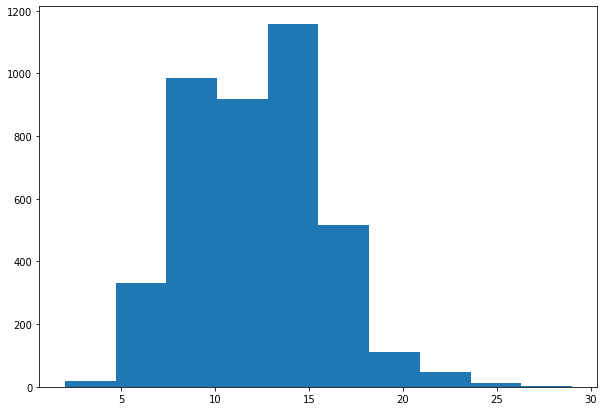

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = []
binsData = np.arange(0,4096)

with open("output", 'r') as file:
  for line in file:
    data.append(int(line))

ig, ax = plt.subplots(figsize =(10, 7))
ax.hist(data)

plt.show()


